<center>

# Flight Delay Predict

#### Data Science Bootcamp Capstone Project
#### Elia Abu-Manneh
##### April 11 2023

</center

## Part 3: Neural Network Modelling

In [1]:
# Imports

import os
import pandas as pd
import numpy as np
from skimage.io import imread
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras import datasets, layers, models
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import re
np.random.seed(0)

%matplotlib inline
import seaborn as sns
import PIL
from PIL import Image
import seaborn as sb

In [2]:
ontime_10423 = pd.read_csv('../processed_data/ontime_10423.csv')

In [3]:
ontime_10423.describe()

,YTD,ORIGIN_AIRPORT_ID,DEP_DELAY,CANCELLED,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_EV,...,DEST_AIRPORT_ID_14869,DEST_AIRPORT_ID_14893,DEST_AIRPORT_ID_14908,DEST_AIRPORT_ID_14986,DEST_AIRPORT_ID_15016,DEST_AIRPORT_ID_15304,DEST_AIRPORT_ID_15370,DEST_AIRPORT_ID_15412,DEST_AIRPORT_ID_15624,DEST_AIRPORT_ID_15919
count,244019.000000,244019.0,239207.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,...,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000,244019.000000
mean,198.873596,10423.0,12.095047,0.019990,0.004094,0.177011,0.028596,0.026387,0.120982,0.000127,...,0.019449,0.004336,0.004996,0.000463,0.013769,0.011983,0.002946,0.000824,0.000582,0.000332
std,107.056546,0.0,51.191644,0.139967,0.063853,0.381679,0.166669,0.160284,0.326107,0.011270,...,0.138098,0.065703,0.070502,0.021514,0.116533,0.108808,0.054202,0.028689,0.024116,0.018216
min,1.000000,10423.0,-29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.000000,10423.0,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,209.000000,10423.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,293.000000,10423.0,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,365.000000,10423.0,2109.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
#y1 = ontime_10423.iloc[:,-64:]
y1 = ontime_10423['DEP_DELAY'] #First Variable that we are trying to predict
y1.fillna(0, inplace=True)

y2 = ontime_10423['CANCELLED'] #Second Variable that we are trying to predict
y2.fillna(0, inplace=True)

X_data = ontime_10423.iloc[:,:-64]
X_data.drop(['ORIGIN_AIRPORT_ID','DEP_DELAY','CANCELLED'], axis=1, inplace=True)

In [5]:
#Finding the weather station associated with Austin Airport
airport_weather_stations = pd.read_csv('../raw_data/airport_weather_2019.csv')

def find_closest_station(input_string):  
    
    # Get a list of all the station names in the dataframe
    station_names = airport_weather_stations['NAME'].tolist()
    
    # Find the closest match to the input string in the list of station names using regex
    pattern = re.compile('.*' + input_string + '.*', flags=re.IGNORECASE)
    closest_matches = [name for name in station_names if re.match(pattern, name)]
    if not closest_matches:
        return None
    closest_match = min(closest_matches, key=len)
    
    # Get the row corresponding to the closest match
    closest_row = airport_weather_stations.loc[airport_weather_stations['NAME'] == closest_match]
    
    # Return the value(s) in the 'STATION' column associated with the closest row
    return closest_row['STATION'].tolist()


In [6]:
weather_station_ID = find_closest_station("Austin")[1]

In [7]:
#converting DATE to YTD in Weather Data
def convert_date_to_ytd(df_name):
    df = globals()[df_name]  # get the DataFrame by name
    
    # Convert DATE column to datetime dtype if it's not already a datetime dtype
    if not pd.api.types.is_datetime64_dtype(df['DATE']):
        df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
  
    df = df.rename(columns={'DATE': 'YTD'})  # rename DATE column to YTD
    df['YTD'] = df['YTD'].dt.dayofyear

    return df

In [8]:
def load_weather_data(weather_station):
    
    years = [2017, 2018, 2019, 2020, 2021, 2022]
    
    # Load weather data for each year and filter based on weather station ID
    dfs = {}
    for year in years:
        filename = f"../processed_data/weather{year}.csv"
        df = pd.read_csv(filename)
        df = df[df['ID'] == weather_station]
        df = convert_date_to_ytd(df)
        # Convert DataFrame to structured numpy array and use as key in dictionary
        key = np.array(df.to_records(index=False)).tolist()
        dfs[key] = df
    
    return dfs


In [9]:
#Loading Weather Data for Austin Airport 
weather2017 = pd.read_csv('../processed_data/weather2017.csv')
weather2017 = weather2017[weather2017['ID'] == weather_station_ID]
weather2017 = convert_date_to_ytd('weather2017')

weather2018 = pd.read_csv('../processed_data/weather2018.csv')
weather2018 = weather2018[weather2018['ID'] == weather_station_ID]
weather2018 = convert_date_to_ytd('weather2018')

weather2019 = pd.read_csv('../processed_data/weather2019.csv')
weather2019 = weather2019[weather2019['ID'] == weather_station_ID]
weather2019 = convert_date_to_ytd('weather2019')

weather2020 = pd.read_csv('../processed_data/weather2020.csv')
weather2020 = weather2020[weather2020['ID'] == weather_station_ID]
weather2020 = convert_date_to_ytd('weather2020')

weather2021 = pd.read_csv('../processed_data/weather2021.csv')
weather2021 = weather2021[weather2021['ID'] == weather_station_ID]
weather2021 = convert_date_to_ytd('weather2021')

weather2022 = pd.read_csv('../processed_data/weather2022.csv')
weather2022 = weather2022[weather2022['ID'] == weather_station_ID]
weather2022 = convert_date_to_ytd('weather2022')

weather_df = pd.concat([weather2017, weather2018, weather2019, weather2020, weather2021, weather2022])

In [10]:
y1.min()

-29.0

0.0


Text(0, 0.5, 'Frequency')

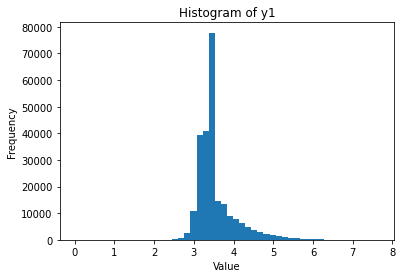

In [11]:
#log transformation of y1
y1 = y1 +29 + 1  #removing any values below 0 by offsetting
print(np.log(y1.min())) #checking for any -inf or negative numbers
#Applying the log transformation
y1 = np.log(y1)

plt.hist(y1, bins = 50)
plt.title('Histogram of y1')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [12]:
#Average weather data for ever specific YTD and adding this to the training data

#dropping the first column (ID)
weather_df = weather_df.drop('ID', axis=1)

#grouping by YTD and calculate the mean of all other columns
weather_df = weather_df.groupby('YTD').mean().reset_index()

In [13]:
weather_df.columns

Index(['YTD', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2',
       'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

In [14]:
#merging X_data with weather_df
X_data_merged = pd.merge(X_data, weather_df, on='YTD')

In [15]:
X_data_merged

,YTD,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_EV,OP_UNIQUE_CARRIER_F9,OP_UNIQUE_CARRIER_G4,OP_UNIQUE_CARRIER_HA,...,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,2,1,0,0,0,0,0,0,0,0,...,112.333333,0.0,0.0,75.666667,122.166667,18.0,318.333333,303.333333,81.333333,109.5
1,2,0,1,0,0,0,0,0,0,0,...,112.333333,0.0,0.0,75.666667,122.166667,18.0,318.333333,303.333333,81.333333,109.5
2,2,1,0,0,0,0,0,0,0,0,...,112.333333,0.0,0.0,75.666667,122.166667,18.0,318.333333,303.333333,81.333333,109.5
3,2,1,0,0,0,0,0,0,0,0,...,112.333333,0.0,0.0,75.666667,122.166667,18.0,318.333333,303.333333,81.333333,109.5
4,2,0,1,0,0,0,0,0,0,0,...,112.333333,0.0,0.0,75.666667,122.166667,18.0,318.333333,303.333333,81.333333,109.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244014,365,0,0,0,0,0,0,0,0,0,...,1.600000,0.0,0.0,109.000000,186.600000,31.4,210.000000,210.000000,85.000000,111.2
244015,365,0,0,0,0,0,0,0,0,0,...,1.600000,0.0,0.0,109.000000,186.600000,31.4,210.000000,210.000000,85.000000,111.2
244016,365,0,0,0,0,0,0,0,0,0,...,1.600000,0.0,0.0,109.000000,186.600000,31.4,210.000000,210.000000,85.000000,111.2
244017,365,0,0,0,0,0,0,0,0,0,...,1.600000,0.0,0.0,109.000000,186.600000,31.4,210.000000,210.000000,85.000000,111.2


In [16]:
#Scaling numerical features 
def ytd_scaler(df):
    numerical_cols = ['YTD','AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2',
       'WDF5', 'WSF2', 'WSF5'] #Last 12 columns
    scaler = MinMaxScaler()
    dfnum = scaler.fit_transform(df[numerical_cols])
    return dfnum

In [17]:
X_num = ytd_scaler(X_data_merged)

In [18]:
X_data_merged.drop(['YTD','AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2',
       'WDF5', 'WSF2', 'WSF5'], axis=1, inplace=True)

In [19]:
#Combining encoded categorical and scaled numerical features
X = np.concatenate((X_data_merged, X_num), axis=1)

In [20]:
#Checking what the input data looks like
print((X[1]).shape)
print(X[1])

# Last 12 columns
# ['YTD','AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'] 

(54,)
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00274725 0.57982456 0.29608153 0.         0.         0.02583799
 0.         0.12813909 1.         1.         0.37973485 0.32178218]


### Delay Model

In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)

In [22]:
#Defining the model
with tf.device('/device:GPU:0'):
    modely1 = keras.Sequential()

    modely1.add(Dense(128,kernel_initializer='LecunNormal', input_dim=54, activation='relu'))

    modely1.add(Dense(256, kernel_initializer='LecunNormal',activation='relu'))

    modely1.add(Dropout(0.25)) 

    modely1.add(Dense(256, kernel_initializer='LecunNormal',activation='relu'))

    modely1.add(Dropout(0.25)) 

    modely1.add(Dense(256, kernel_initializer='LecunNormal',activation='relu'))
         
    modely1.add(Dense(1, activation='linear'))

    modely1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7040      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2

In [23]:
def rmse(y_true, y_pred): #defining the Root Mean Squared Error function
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [24]:
# Compile model
#model.compile(loss=CategoricalCrossentropy,optimizer='adam', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    modely1.compile(
        optimizer='adam',  # using the Adam optimizer
        loss='mean_squared_error',  # using mean squared error as the loss function
        metrics=[rmse]  # using mean squared error as the evaluation metric
    )

In [25]:
# Train the model and store the history
with tf.device('/device:GPU:0'):
    historyy1 = modely1.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/8
6101/6101 [==============================] - 28s 4ms/step - loss: 0.2846 - rmse: 0.5124 - val_loss: 0.2529 - val_rmse: 0.4852
Epoch 2/8
6101/6101 [==============================] - 28s 5ms/step - loss: 0.2510 - rmse: 0.4859 - val_loss: 0.2464 - val_rmse: 0.4800
Epoch 3/8
6101/6101 [==============================] - 28s 5ms/step - loss: 0.2497 - rmse: 0.4852 - val_loss: 0.2453 - val_rmse: 0.4816
Epoch 4/8
6101/6101 [==============================] - 28s 5ms/step - loss: 0.2486 - rmse: 0.4836 - val_loss: 0.2468 - val_rmse: 0.4839
Epoch 5/8
6101/6101 [==============================] - 27s 4ms/step - loss: 0.2482 - rmse: 0.4834 - val_loss: 0.2469 - val_rmse: 0.4840
Epoch 6/8
6101/6101 [==============================] - 27s 4ms/step - loss: 0.2478 - rmse: 0.4828 - val_loss: 0.2435 - val_rmse: 0.4784
Epoch 7/8
6101/6101 [==============================] - 27s 4ms/step - loss: 0.2474 - rmse: 0.4821 - val_loss: 0.2449 - val_rmse: 0.4780
Epoch 8/8
6101/6101 [===========================

In [26]:
#manually checking the loss values
dfy1 = pd.DataFrame(historyy1.history)
dfy1.head(3)

,loss,rmse,val_loss,val_rmse
0,0.284584,0.512385,0.252907,0.485225
1,0.251008,0.485862,0.246442,0.479968
2,0.249706,0.485242,0.245309,0.481615


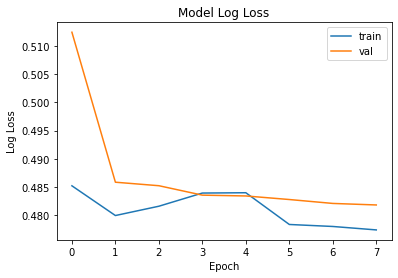

In [31]:
#plotting the training and validation loss over the epochs
plt.plot(historyy1.history['val_rmse'])
plt.plot(historyy1.history['rmse'])
plt.title('Model Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [32]:
#exponentiating the loss values back to minutes
dfy1 = pd.DataFrame(historyy1.history)
dfy1 = dfy1.applymap(lambda x: np.exp(x))
dfy1.head(3)

,loss,rmse,val_loss,val_rmse
0,1.329208,1.669268,1.287764,1.624540
1,1.285321,1.625576,1.279465,1.616023
2,1.283648,1.624567,1.278016,1.618686


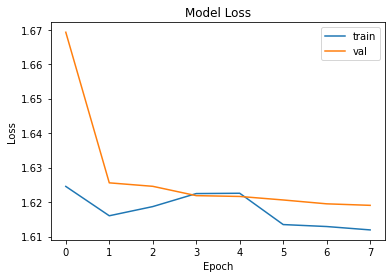

In [33]:
plt.plot(dfy1['val_rmse'])
plt.plot(dfy1['rmse'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

ADD WEATHER API HERE

In [34]:
def get_pred_delay(row_number):
    new_data = X[row_number].reshape(-1,54)  #sample input
    #type(X[1]) is an numpy.ndarray

    # Make prediction with the model
    raw_prediction = modely1.predict(new_data)
    #print(raw_prediction)

    ylabels= ontime_10423['DEP_DELAY']
    correct_label = ylabels[row_number]

    tranformed_prediction = np.exp(raw_prediction) -30
    return tranformed_prediction, correct_label

In [72]:
r = 753 #row number - example of an input data
print(get_pred_delay(r)[0])
print(get_pred_delay(r)[1])

[[5.7115364]]
6.0


### Cancellation Model

In [81]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)

In [82]:
#Defining the model
with tf.device('/device:GPU:0'):
    modely2 = keras.Sequential()

    modely2.add(Dense(128,kernel_initializer='LecunNormal', input_dim=54, activation='relu'))

    modely2.add(Dense(256, kernel_initializer='LecunNormal',activation='relu'))

    modely2.add(Dropout(0.25)) 

    modely2.add(Dense(256, kernel_initializer='LecunNormal',activation='relu'))

    modely2.add(Dropout(0.25)) 

    modely2.add(Dense(256, kernel_initializer='LecunNormal',activation='relu'))
         
    modely2.add(Dense(1, activation='linear'))

    modely2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               7040      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [83]:
def rmse(y_true, y_pred): #defining the Root Mean Squared Error function
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [84]:
# Compile model
#model.compile(loss=CategoricalCrossentropy,optimizer='adam', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    modely2.compile(
        optimizer='adam',  # using the Adam optimizer
        loss='mean_squared_error',  # using mean squared error as the loss function
        metrics=[rmse]  # using mean squared error as the evaluation metric
    )

In [85]:
# Train the model and store the history
with tf.device('/device:GPU:0'):
    historyy2 = modely2.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/8
6101/6101 [==============================] - 29s 5ms/step - loss: 0.0194 - rmse: 0.1053 - val_loss: 0.0199 - val_rmse: 0.1049
Epoch 2/8
6101/6101 [==============================] - 29s 5ms/step - loss: 0.0188 - rmse: 0.1032 - val_loss: 0.0196 - val_rmse: 0.1057
Epoch 3/8
6101/6101 [==============================] - 30s 5ms/step - loss: 0.0187 - rmse: 0.1030 - val_loss: 0.0195 - val_rmse: 0.1040
Epoch 4/8
6101/6101 [==============================] - 30s 5ms/step - loss: 0.0186 - rmse: 0.1026 - val_loss: 0.0195 - val_rmse: 0.1074
Epoch 5/8
6101/6101 [==============================] - 30s 5ms/step - loss: 0.0185 - rmse: 0.1014 - val_loss: 0.0194 - val_rmse: 0.1031
Epoch 6/8
6101/6101 [==============================] - 30s 5ms/step - loss: 0.0185 - rmse: 0.1020 - val_loss: 0.0194 - val_rmse: 0.1027
Epoch 7/8
6101/6101 [==============================] - 31s 5ms/step - loss: 0.0185 - rmse: 0.1020 - val_loss: 0.0195 - val_rmse: 0.1070
Epoch 8/8
6101/6101 [===========================

In [86]:
#manually checking the loss values
dfy2 = pd.DataFrame(historyy2.history)
dfy2.head(3)

,loss,rmse,val_loss,val_rmse
0,0.019393,0.105295,0.019873,0.104895
1,0.018842,0.103170,0.019629,0.105664
2,0.018689,0.102994,0.019453,0.103987


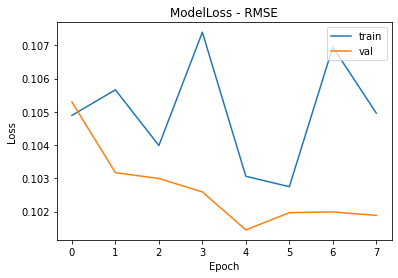

In [87]:
#plotting the training and validation loss over the epochs
plt.plot(historyy2.history['val_rmse'])
plt.plot(historyy2.history['rmse'])
plt.title('ModelLoss - RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

ADD WEATHER API HERE!

In [88]:
def get_pred_cancel(row_number):
    new_data = X[row_number].reshape(-1,54)  #sample input
    #type(X[1]) is an numpy.ndarray

    # Make prediction with the model
    raw_prediction = modely2.predict(new_data)
    #print(raw_prediction)

    ylabels= ontime_10423['CANCELLED']
    correct_label = ylabels[row_number]
    
    return raw_prediction, correct_label

In [89]:
r = 42345 #row number - example of an input data
print(get_pred_cancel(r)[0])
print(get_pred_cancel(r)[1])

[[0.01769858]]
0.0


In [92]:
print(modely2.predict((X[53].reshape(1,54))))

[[0.01769858]]


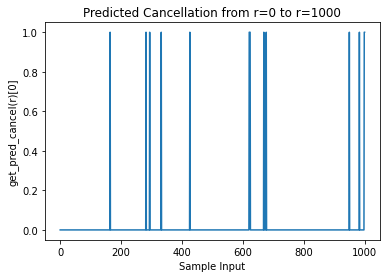

In [91]:
#Checking cancellation frequency

#defining the range of values for r
r_values = range(0, 1001)

#creating a sample list of y_values 
y_values = [get_pred_cancel(r)[1].reshape(1,) for r in r_values]

#plotting
plt.plot(r_values, y_values)
plt.xlabel('Sample Input')
plt.ylabel('get_pred_cancel(r)[0]')
plt.title('Predicted Cancellation from r=0 to r=1000')
plt.show()

Lookup: 
* Try changing: XgBoost, Linear Regression
* Be able to explain to explain the tools I used vs. the ones I didn't use

Eg: I started with Linear Regression, it worked well
Then I tried XGboost, a bit better
Then I tried Neural Networks

In [ ]:
https://www.tensorflow.org/guide/keras/save_and_serialize